# Camera Calibration.

Cameras are often distorted because of their lenses or sensors. It's helpful to be able to undistort your image in self driving applications so you can get an accurate representation of the world. Speficially it can be used to create a birds eye view of your path and it's needed to make visual odometry work.


This notebooks shows two different apporaches to undistort images. 
1. For standard cameras that only have minor distortions. 
2. For fisheye cameras with lots of distortion. 

In [1]:
import os
import glob

In [2]:
import pandas as pd
import numpy as np
import cv2
assert cv2.__version__[0] == '3', 'The fisheye module requires opencv version >= 3.0.0'

%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image

## The data
For both calibration methods you need a collection of images of a checkerboard. To get this with my donkey car, I changed the camera resolution to 640x480 and my drive loop hz to 3 then started it with the drive command and pointed it at a screen that was showing the checkerboard. After moving it around in many different angles I collected ~200 images that are saved in this folder...

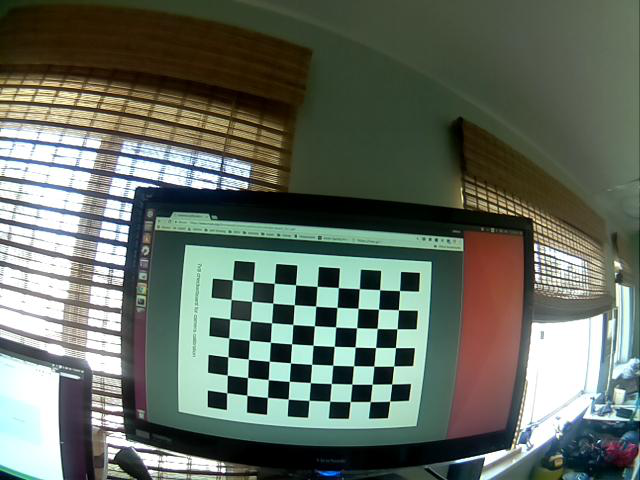

In [3]:
images_folder_path = './data/fisheye_camera_calibration/'
img_list = glob.glob(os.path.join(images_folder_path,'*.jpg'))
img = Image.open(os.path.join(img_list[0]))
img

In [4]:
cb_w, cb_h =  CHECKERBOARD_SIZE = (7,9)

h, w = img_size = np.array(img).shape[:2]
img_size

(480, 640)

### The usual method of clibrating a camera

This method is taken straight from the [OpenCV tutorial](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html) and can work well for cameras with minor distortions.

In [5]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((cb_w*cb_h, 3), np.float32)
objp[:,:2] = np.mgrid[0:cb_w,0:cb_h].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

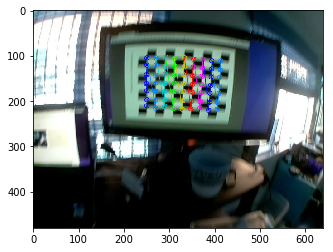

In [6]:
for fname in img_list[0:50]:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD_SIZE, None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, CHECKERBOARD_SIZE, corners2,ret)
        
plt.imshow(img)


In [7]:
#Get the camera properties.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, 
                                                   gray.shape[::-1],None,None)

#ret
ret

1.6465638947333756

In [8]:
#camera matrix
np.round(mtx)

array([[ 834.,    0.,  304.],
       [   0.,  817.,  248.],
       [   0.,    0.,    1.]])

In [9]:
#distance coefficients
np.round(dist)

array([[ -2.,  11.,  -0.,   0., -27.]])

In [10]:
#Scale coeficients to the image and unit vector 1.
img = cv2.imread(img_list[2])
h,  w = img.shape[:2]
scaled_mtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

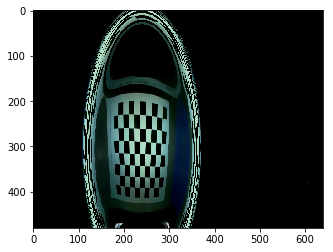

In [11]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, scaled_mtx)
plt.imshow(dst)

Here we can see that this is not the result we want. So lets try the calibration method for the fisheye lense.

## Calibrate a fisheye camera.

This code is mostly copied by Kenneth Jaing's [Medium post](https://medium.com/@kennethjiang/calibrate-fisheye-lens-using-opencv-333b05afa0b0).

In [12]:
#not sure what this does
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW

In [13]:
"""
TODO: these next two stips could be the same as above 
method but the objpoints is a different shape.
"""
#create a new object point array
objp = np.zeros((1, cb_w*cb_h, 3), np.float32)
objp[0,:,:2] = np.mgrid[0:cb_w, 0:cb_h].T.reshape(-1, 2)
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

In [14]:
#generate img and object point points
for fname in img_list:
    
    # Find the chess board corners
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD_SIZE, 
                                             cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)
        
img_count = len(imgpoints)
print("Found {} valid images for calibration".format(img_count))

Found 187 valid images for calibration


In [15]:
#Calculate the camera properties.
mtx= np.zeros((3, 3))
dist = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(img_count)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(img_count)]

rms, _, _, _, _ = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        img_size,
        mtx,
        dist,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )

In [16]:
mtx

array([[ 772.26683142,    0.        ,  303.6908292 ],
       [   0.        ,  778.03331128,  240.52201163],
       [   0.        ,    0.        ,    1.        ]])

In [17]:
#camera matrix
np.round(mtx)

array([[ 772.,    0.,  304.],
       [   0.,  778.,  241.],
       [   0.,    0.,    1.]])

In [18]:
#distribution coefficients
dist

array([[ -1.65260527],
       [  5.7104838 ],
       [-23.89860722],
       [ 55.40237623]])

In [19]:
def undistort(img_arr):
    
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(mtx, dist, np.eye(3), 
                                                     mtx, (w, h), cv2.CV_16SC2)

    undistorted_img = cv2.remap(img_arr, map1, map2, interpolation=cv2.INTER_LINEAR, 
                                borderMode=cv2.BORDER_CONSTANT)

    return undistorted_img



In [20]:
#undistort image
img = Image.open(img_list[60])
undistorted = undistort(np.array(img))

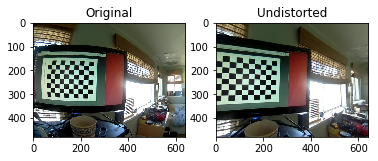

In [21]:
#see difference between the two
fig = plt.figure()
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(img)
a.set_title('Original')
a=fig.add_subplot(1,2,2)
a.set_title('Undistorted')
imgplot = plt.imshow(undistorted)


In [22]:
#scale to image_size = 120x160 (4x smaller)
scaled_mtx = mtx/4
scaled_mtx

array([[ 193.06670785,    0.        ,   75.9227073 ],
       [   0.        ,  194.50832782,   60.13050291],
       [   0.        ,    0.        ,    0.25      ]])

In [23]:

focal_length = fx, fy = scaled_mtx[0,0], scaled_mtx[1,1]
focal_length


(193.06670785466687, 194.50832782035627)

In [24]:
optical_axis_center = cx, cy = scaled_mtx[0,2], scaled_mtx[1,2]
optical_axis_center

(75.922707300500363, 60.13050290737069)

In [25]:
#distortion coefficients
k1, k2, k3, k4 = dist #
dist

array([[ -1.65260527],
       [  5.7104838 ],
       [-23.89860722],
       [ 55.40237623]])

### Other sources
calibration matrix http://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=initundistortrectifymap
